## Data Ingestion (CSV -> Scenario)

In [24]:
import math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, NamedTuple
import time

In [ ]:
df = pd.read_csv("customers.csv")
# make a depot around the center
depot_x = df["x"].mean()
depot_y = df["y"].mean()
depot = (depot_x, depot_y)

# make customers to a coordinate list

coords_df = df[["x","y"]]
customers = list(zip(coords_df["x"], coords_df["y"]))

#distance matrix
def euclidean(a, b):
    return math.hypot(a[0]- b[0], a[1] - b[1])

def distance_matrix(depot, customers):
    pts = [tuple(depot)] + [tuple(c) for c in customers]
    n = len(pts)
    dmat = np.zeros((n,n), dtype = float)
    for i in range(n):
        for j in range(n):
            if i == j:
                dmat[i, j] = 0.0
            else:
                dmat[i, j] = euclidean(pts[i], pts[j])
    
    return dmat

#choose number of vihicles






## Representation

Goal : choose a chromosome format for VRP, then decode it into actual vehicle routes, and define the total distance

In [26]:
class Individual(NamedTuple):
    perm: List[int]  # visit order
    cuts: List[int]  # split it to routes for each vehicle  (could also be put in dic check later)

# random intializer

def random_individual(N: int, V: int, rng:random.Random) -> Individual:
    # random permutation of all customers
    perm = list(range(1, N+1))
    rng.shuffle(perm)

    #choose exactly V-1 unique cut positions
    # here maybe an error handler later

    cuts = sorted(rng.sample(range(1, N), V-1))  # random cuts same number as number of vehicles

    return Individual(perm=perm, cuts=cuts)

# decode into actualy routes

def decode_routes(ind: Individual, V:int) -> List[List[int]]:
    perm = ind.perm
    cuts = ind.cuts

    routes = []
    prev = 0
    for c in cuts:
        routes.append(perm[prev:c])
        prev = c
    routes.append(perm[prev:])

    # maybe sanity test here later
    return routes

def route_distance(route: List[int], dmat) -> float:
    total = 0.0
    prev = 0
    for c in route:
        total += dmat[prev, c]
        prev = c
    total += dmat[prev, 0] # final route to back to depot
    return float(total)

def total_distance(ind: Individual, dmat, V: int) -> float:
    routes = decode_routes(ind, V)
    return sum(route_distance(r, dmat) for r in routes)


## GA Operators

add
1. fitness
2. selection
3. crossover
4. mutation

In [27]:
def fitness(ind: Individual, dmat, V: int) -> float:
    # inorder to maximize fitness we return the negative of the total distance
    return -total_distance(ind, dmat, V)

def tournament_selection_idx(fitnesses: List[float], k: int, rng: random.Random) -> int:
    # return index of selected parent via k-tournament where higher fitness wins
    cand = [rng.randrange(len(fitnesses)) for i in range(k)]
    return max(cand, key=lambda i: fitnesses[i])

def order_crossover(p1: List[int], p2: List[int], rng: random.Random) -> Tuple[List[int], List[int]]:
    n = len(p1)
    a, b = sorted([rng.randrange(n), rng.randrange(n)])
    def ox(a, b, x, y):
        child = [None]*n
        child[a:b+1] = x[a:b+1]
        fill = [g for g in y if g not in child]
        pos = 0
        for i in range(n):
            if child[i] is None:
                child[i] = fill[pos]; pos +=1
        return child
    return ox(a,b,p1,p2), ox(a,b,p2,p1)

def repair_cuts(cuts: List[int], N: int, V:int, rng: random.Random) -> List[int]:
    clamped = [min(max(1, c), N-1) for c in cuts]
    uniq = sorted(set(clamped))
    need = (V-1)- len(uniq)
    if need > 0:
        #fill missing positions 
        pool = [c for c in range(1,N) if c not in uniq]
        add = rng.sample(pool, need)
        uniq = sorted(uniq + add)
    elif need < 0:
        # trim number of cuts if to many
        drop = rng.sample(range(len(uniq)), -need)
        keep = [i for i in range(len(uniq)) if i not in drop]
        uniq = [uniq[i] for i in keep]
    return uniq

def cuts_crossover(c1: List[int], c2: List[int], N: int, V: int, rng: random.Random) -> Tuple[List[int], List[int]]:
    # one point crossover between sorted cuts and then repair
    if not c1 and not c2:
        return [], []
    a = rng.randrange(0, max(len(c1), 1))
    ch1 = sorted(c1[:a] + c2[a:])
    ch2 = sorted(c2[:a] + c1[a:])
    ch1 = repair_cuts(ch1, N, V, rng)
    ch2 = repair_cuts(ch2, N, V, rng)
    return ch1, ch2

def swap_mutation_perm(p: List[int], p_mut:float, rng: random.Random) -> List[int]:
    q = p[:]
    if rng.random() < p_mut and len(q) >= 2:
        i , j = rng.sample(range(len(q)), 2)
        q[i], q[j] = q[j], q[i]
    return q

'''add maybe inversion mutuation later'''

def jitter_mutation_cuts(cuts: List[int], N:int, V:int, p_mut: float, rng: random.Random) -> List[int]:
    q = cuts[:]
    if rng.random() < p_mut and q:
        i = rng.randrange(len(q))
        shift = rng.choice([1,-1])
        q[i] = min(max(1, q[i] + shift), N-1)
    return repair_cuts(q, N, V, rng)




    


## GA Engine

In [ ]:
def genetic_algorithm(dmat, N=50, V=26, pop_size=120, generations=400, k_tourn=3, pc=0.9, pm_perm=0.2, pm_cuts=0.2, seed=0, log_convergence=False):
    rng = random.Random(seed)

    # init population
    pop = [random_individual(N, V, rng) for _ in range(pop_size)]
    fits = [fitness(ind, dmat, V) for ind in pop]

    best_hist = []  # best in each generation in order to track if the algorithm works

    # evolve
    for _ in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            # select parents
            a = tournament_selection_idx(fits, k=k_tourn, rng=rng)
            b = tournament_selection_idx(fits, k=k_tourn, rng=rng)
            p1, p2 = pop[a], pop[b]

            # crossover
            if rng.random() < pc:
                ch1_perm, ch2_perm = order_crossover(p1.perm, p2.perm, rng)
                ch1_cuts, ch2_cuts = cuts_crossover(p1.cuts, p2.cuts, N, V, rng)
            else:
                ch1_perm, ch2_perm = p1.perm[:], p2.perm[:]
                ch1_cuts, ch2_cuts = p1.cuts[:], p2.cuts[:]

            # mutation
            ch1_perm = swap_mutation_perm(ch1_perm, pm_perm, rng)
            ch2_perm = swap_mutation_perm(ch2_perm, pm_perm, rng)
            ch1_cuts = jitter_mutation_cuts(ch1_cuts, N, V, pm_cuts, rng)
            ch2_cuts = jitter_mutation_cuts(ch2_cuts, N, V, pm_cuts, rng)

            # children
            c1 = Individual(perm=ch1_perm, cuts=ch1_cuts)
            c2 = Individual(perm=ch2_perm, cuts=ch2_cuts)
            new_pop.extend([c1, c2])

        # replacement
        pop = new_pop[:pop_size]
        fits = [fitness(ind, dmat, V) for ind in pop]

        if log_convergence:
            best_idx = max(range(pop_size), key=lambda i: fits[i])
            best_hist.append(-fits[best_idx])  # store positive distance

    # best at the end
    best_idx = max(range(pop_size), key=lambda i: fits[i])
    best = pop[best_idx]
    best_dist = -fits[best_idx]

    return best, best_dist, best_hist


## Experiments

## Visualization

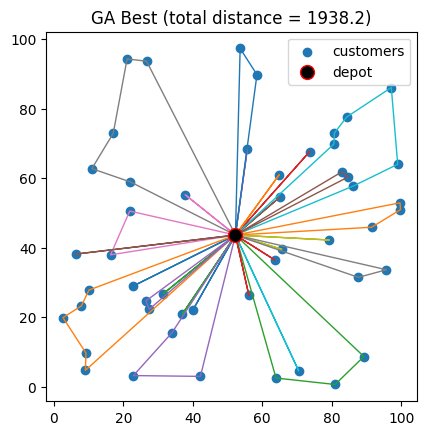

In [44]:


def plot_routes(ind, customers, depot, n_vehicles, number_points=False, title=None):
   
    routes = decode_routes(ind, n_vehicles)

    # scatter: customers + depot
    xs = [xy[0] for xy in customers]
    ys = [xy[1] for xy in customers]
    plt.figure()
    plt.scatter(xs, ys, label="customers")
    plt.scatter([depot[0]], [depot[1]], marker=".", s=400, label="depot", edgecolors= "red", color ="black", zorder=10)

    # draw each route
    for r in routes:
        if not r:
            continue
        # build path: depot (0) -> r -> depot (0)
        xs_path = [depot[0]] + [customers[i-1][0] for i in r] + [depot[0]]
        ys_path = [depot[1]] + [customers[i-1][1] for i in r] + [depot[1]]
        plt.plot(xs_path, ys_path, linewidth=1.0)

    plt.gca().set_aspect("equal", adjustable="box")
    plt.legend()
    plt.title(title or f"Decoded Routes (vehicles={n_vehicles})")
    plt.show()
dmat = distance_matrix(depot, customers) 
best_ind, best_dist, best_hist = genetic_algorithm(dmat, N=50, V=26, pop_size=120, generations=400, k_tourn=3, pc=0.9, pm_perm=0.2, pm_cuts=0.2, seed=0, log_convergence=True)
plot_routes(best_ind, customers, depot, n_vehicles=26, number_points=False,
            title=f"GA Best (total distance = {best_dist:.1f})")



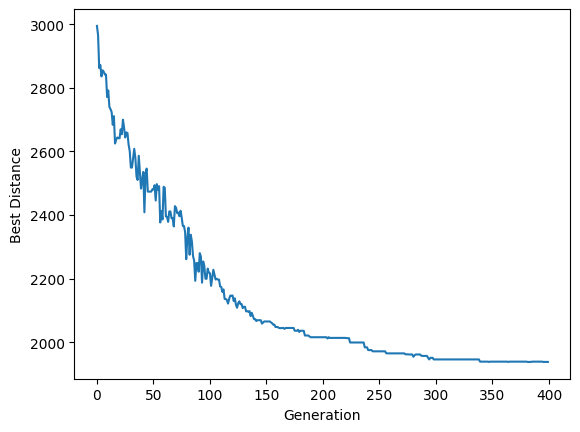

In [36]:
# inprovement through generations
import matplotlib.pyplot as plt
plt.plot(best_hist)
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.show()

we can see that the distance was gradually decreasing with generations so we know that our algorithm really worked
